# Comparison of NSF and PRISMO on SlideSeq Data from NSF Paper

In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pickle as pkl
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm, ListedColormap
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

from famo.utils_downstream import match
from famo.utils_io import load_model
from famo.core import CORE

from data_loader import load_nsf_slideseq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## PRISMO

In [2]:
# adata = load_nsf_slideseq()

# prismo_model = CORE(device="cuda:0")
# prismo_model.fit(
#     data=adata,
#     n_factors=10,
#     weight_prior="Normal",
#     factor_prior="GP",
#     likelihoods="GammaPoisson",
#     covariates_obsm_key="spatial",
#     early_stopper_patience=30,
#     lr=5e-2,
#     plot_data_overview=False,
#     save_path="results/prismo",
#     gp_n_inducing=1000,
#     gp_kernel="Matern",
#     gp_matern_kernel_nu=1.5,
#     seed=5432,
#     batch_size=1000,
#     print_every=10,
#     nonnegative_factors=True,
#     nonnegative_weights=True,
#     init_factors="nmf"
# )

In [3]:
# prismo_model = load_model("results/prismo")

# z_prismo = prismo_model.get_factors()["group_1"].values
# w_prismo = prismo_model.get_weights()["view_1"].T.values

# # postprocess scales
# z_prismo_sum = np.sum(z_prismo, axis=0)
# z_prismo = z_prismo / z_prismo_sum.reshape(1, -1)
# w_prismo = w_prismo * z_prismo_sum
# w_prismo_sum = np.sum(w_prismo, axis=1, keepdims=True)
# w_prismo = w_prismo / w_prismo_sum

# pkl.dump({"z" : z_prismo, "w" : w_prismo}, open("results/prismo_lvs.pkl", "wb"))

In [4]:
z_prismo, w_prismo = pkl.load(open("results/prismo_lvs.pkl", "rb")).values()

## NSF

In [5]:
# requires the nsf-paper conda environment to be activated

# import pickle as pkl

# import numpy as np
# import spatial_factorization as sf
# from data_loader import load_nsf_slideseq
# from tensorflow.data import Dataset

# adata = load_nsf_slideseq()

# # prepare data for SpatialFactorization model
# data = {
#     "X": adata.obsm["spatial"].copy().astype("float32"),
#     "Y": adata.layers["counts"].toarray().astype("float32"),
#     "sz" : np.ones((adata.n_obs, 1), dtype="float32"),
#     "idx" : np.arange(adata.n_obs)
#     }
# data_tf = Dataset.from_tensor_slices(data)
# data_tf = data_tf.batch(adata.n_obs)
# inducing_locations = sf.misc.kmeans_inducing_pts(data["X"], 1000)

# # setup and train SpatialFactorization model
# sf_model = sf.SpatialFactorization(
#     J=adata.n_vars,
#     L=10,
#     Z=inducing_locations,
#     lik="poi",
#     nonneg=True,
# )
# sf_model.init_loadings(data["Y"])
# trainer = sf.ModelTrainer(sf_model)
# trainer.train_model(data_tf, adata.n_obs, None)

In [6]:
# # obtain inferred latent variables
# z_sf = np.exp(sf_model.sample_latent_GP_funcs(data["X"], S=100).numpy().mean(axis=0).T)
# w_sf = sf_model.get_loadings()

# # postprocess scales
# z_sf_sum = np.sum(z_sf, axis=0)
# z_sf = z_sf / z_sf_sum.reshape(1, -1)
# w_sf = w_sf * z_sf_sum
# w_sf_sum = np.sum(w_sf, axis=1, keepdims=True)
# w_sf = w_sf / w_sf_sum

# pkl.dump({"z" : z_sf, "w" : w_sf}, open("results/sf.pkl", "wb"))

In [7]:
z_sf, w_sf = pkl.load(open("results/sf.pkl", "rb")).values()

## Factor Matching

In [8]:
z_inds, z_signs = match(z_sf, z_prismo, dim=-1)

z_prismo = z_prismo[:, z_inds]
w_prismo = w_prismo[:, z_inds]

corr = []
for factor in range(10):
    corr.append(pearsonr(z_prismo[:, factor], z_sf[:, factor])[0])
corr = np.array(corr)
factor_order = corr.argsort()[::-1]
corr = corr[factor_order]

z_prismo = z_prismo[:, factor_order]
w_prismo = w_prismo[:, factor_order]

z_sf = z_sf[:, factor_order]
w_sf = w_sf[:, factor_order]

## Plots

In [9]:
adata = load_nsf_slideseq()

In [15]:
def plot_factors(z_prismo, z_other, x, name_other: str, save_path=None, s: int=10, figsize=(20, 10)):
    n_factors = z_prismo.shape[-1]

    if np.all(z_prismo >= 0) and np.all(z_other >= 0):
        nonnegative = True
        cmap = ListedColormap(plt.get_cmap('vlag_r')(np.linspace(0.5, 1, 256)))
    else:
        nonnegative = False
        cmap = plt.get_cmap('vlag_r')

    fig, axs = plt.subplots(3, n_factors, figsize=figsize, gridspec_kw={'height_ratios': [1, 1, 0.1]})

    for factor in range(n_factors):
        if nonnegative:
            prismo_norm = "linear"
            other_norm = "linear"
        else:
            prismo_norm = TwoSlopeNorm(vcenter=0, vmin=z_prismo[:, factor].min(), vmax=z_prismo[:, factor].max())
            other_norm = TwoSlopeNorm(vcenter=0, vmin=z_other[:, factor].min(), vmax=z_other[:, factor].max())

        sc_prismo = axs[0][factor].scatter(x[:, 0], -1 * x[:, 1], s=s, c=z_prismo[:, factor], cmap=cmap, zorder=2, norm=prismo_norm, rasterized=True)
        sc_other = axs[1][factor].scatter(x[:, 0], -1 * x[:, 1], s=10, c=z_other[:, factor], cmap=cmap, zorder=1, norm=other_norm, rasterized=True)

        divider_prismo = make_axes_locatable(axs[0][factor])
        divider_other = make_axes_locatable(axs[1][factor])
        cax_prismo = divider_prismo.append_axes("bottom", size="5%", pad=0.1)
        cax_other = divider_other.append_axes("bottom", size="5%", pad=0.1)
        cbar_prismo = fig.colorbar(sc_prismo, cax=cax_prismo, orientation='horizontal')
        cbar_other = fig.colorbar(sc_other, cax=cax_other, orientation='horizontal')
        if nonnegative:
            cbar_prismo.ax.set_xticks([0.0, 2 * z_prismo[:, factor].max() / 3])
            cbar_prismo.formatter = ticker.FuncFormatter(lambda x, pos: f'{x:.0e}')
            cbar_other.ax.set_xticks([0.0, 2 * z_other[:, factor].max() / 3])
            cbar_other.formatter = ticker.FuncFormatter(lambda x, pos: f'{x:.0e}')
        else:
            cbar_prismo.ax.set_xticks([z_prismo[:, factor].min(), z_prismo[:, factor].max()])
            cbar_other.ax.set_xticks([z_other[:, factor].min(), z_other[:, factor].max()])

        axs[0][factor].set_title(f"Factor {factor + 1}")

        for i in range(2):
            ax = axs[i][factor]
            ax.grid(which='both', zorder=0, alpha=0.5)
            ax.set_aspect(1.)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.tick_params(axis='both', which='both', length=0)

        # Correlation bar
        ax = axs[2][factor]
        corr = round(pearsonr(z_prismo[:, factor], z_other[:, factor])[0], 2)
        ax.axis("off")
        ax.barh([0], [1], color='darkgray', height=1)
        ax.barh([0], [corr], color=plt.get_cmap("vlag_r")(0), height=1)
        ax.text(0.5, 0, f'R={corr:.2f}', va='center', ha='center', color='white', transform=ax.transData)
        ax.set_xticks([])
        ax.set_yticks([])

    axs[0, 0].set_ylabel("PRISMO", fontsize=12)
    axs[1, 0].set_ylabel(name_other, fontsize=12)

    plt.tight_layout()
    if save_path is not None:
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig(save_path, transparent=True, dpi=300)

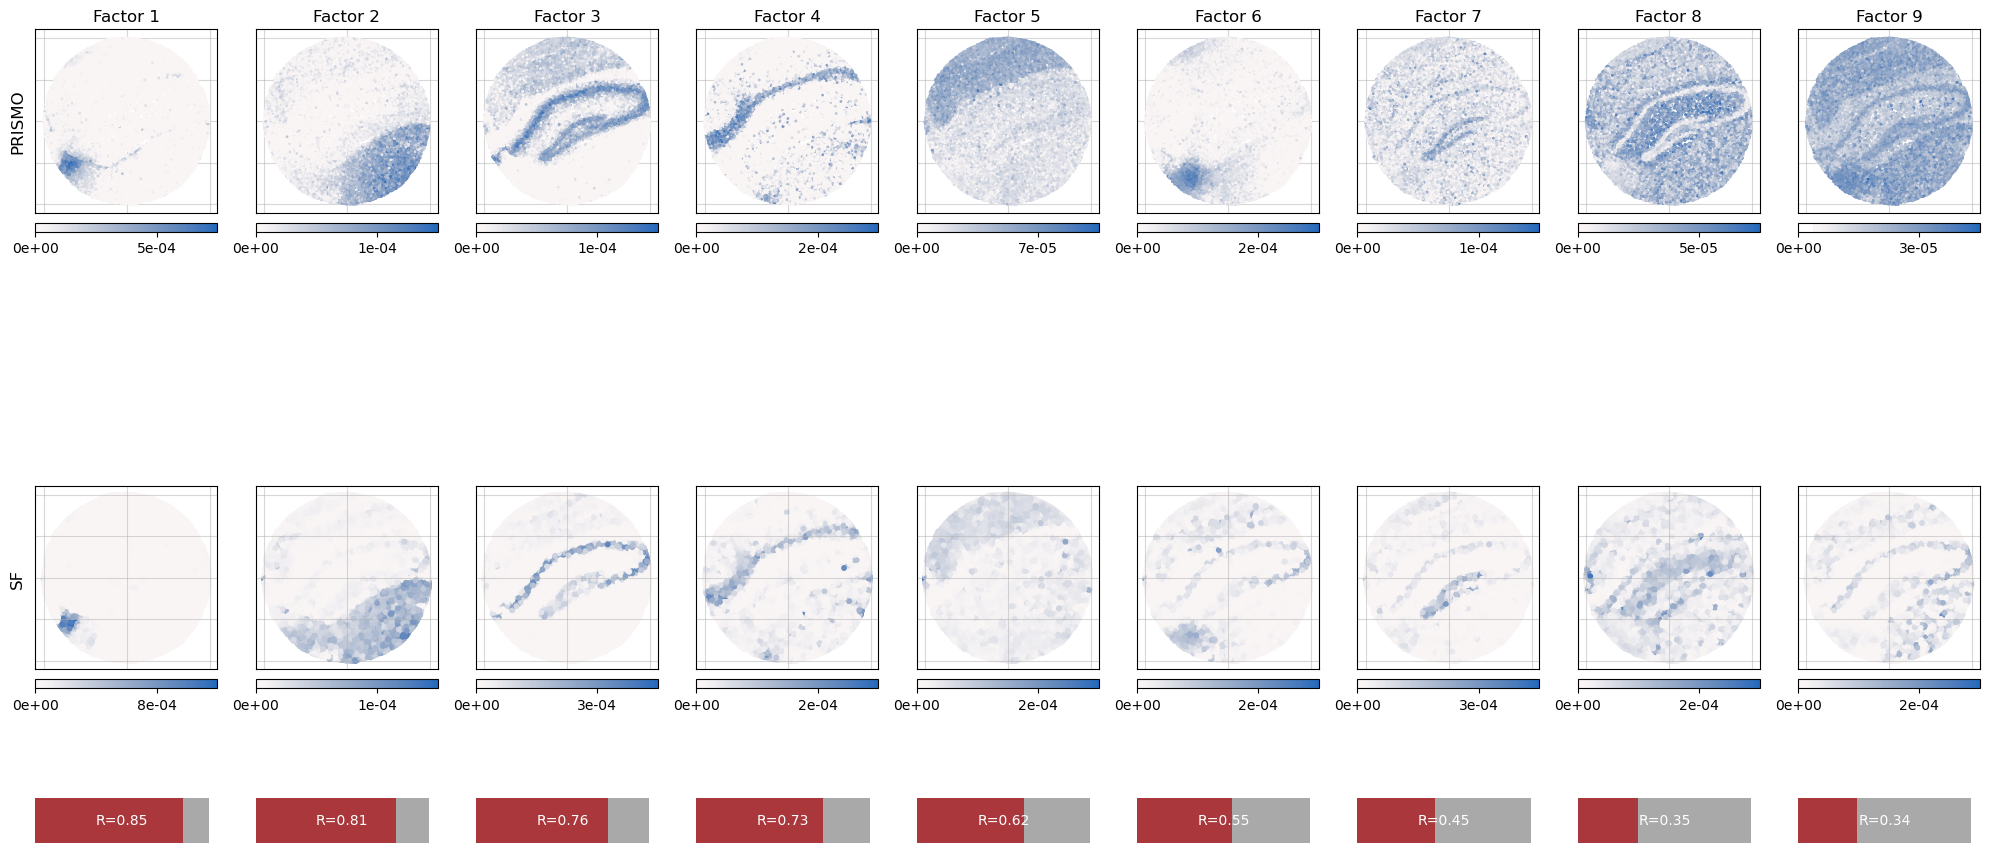

In [16]:
n_factors = 9

plot_factors(z_prismo[:, :n_factors], z_sf[:, :n_factors], x=adata.obsm["spatial"], name_other="SF", s=1, save_path="plots/factors.svg", figsize=(20, 10))

In [20]:
def plot_weights(w_1, w_2, save_path=None):
    fig, axs = plt.subplots(2, w_1.shape[1], figsize=(20, 3.4), gridspec_kw={'height_ratios': [1, 0.1]})

    for factor in range(w_1.shape[1]):
        ax = axs[0][factor]
        ax.scatter(w_1[:, factor], w_2[:, factor], s=0.1, zorder=2, rasterized=True, color=plt.get_cmap("vlag")(0))
        ax.set_title(f"Factor {factor + 1}")
        ax.grid(which='both', zorder=0, alpha=0.5)
        ax.set_aspect(1.)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel("PRISMO")
        ax.set_ylabel("SpatialFactorization")

        ax = axs[1][factor]
        corr = round(pearsonr(w_1[:, factor], w_2[:, factor])[0], 2)
        ax.axis("off")
        ax.barh([0], [1], color='darkgray', height=1)
        ax.barh([0], [corr], color=plt.get_cmap("vlag_r")(0), height=1)
        ax.text(0.5, 0, f'R={corr:.2f}', va='center', ha='center', color='white', transform=ax.transData)
        ax.set_xticks([])
        ax.set_yticks([])

    for i in range(1, w_1.shape[1]):
        axs[0, i].set_yticklabels([])
        axs[0, i].set_ylabel("")

    plt.tight_layout()
    if save_path is not None:
        plt.rcParams['svg.fonttype'] = 'none'
        plt.savefig(save_path, transparent=True, dpi=300)

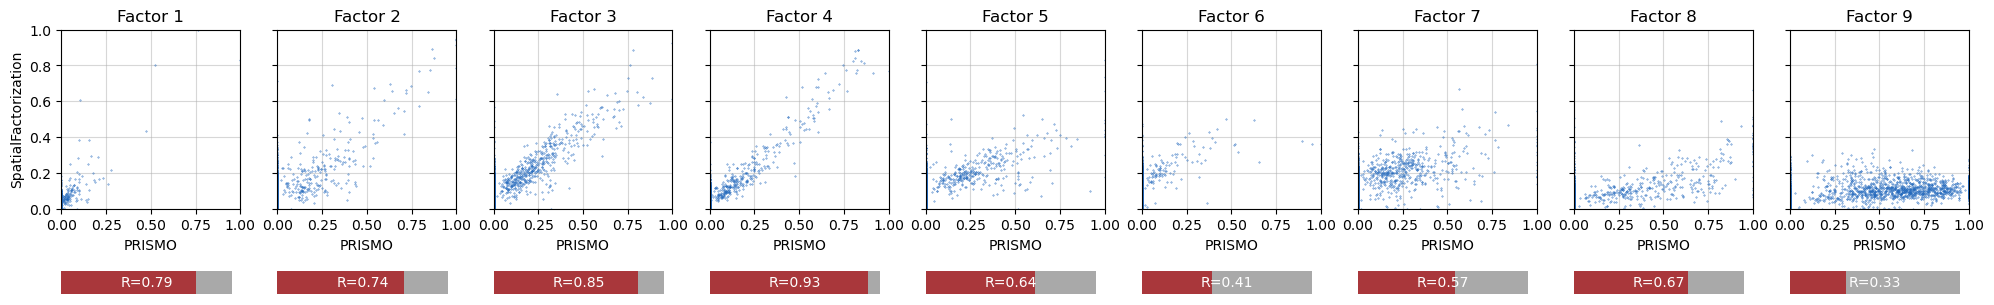

In [23]:
n_factors = 9

plot_weights(w_prismo[:, :n_factors], w_sf[:, :n_factors], save_path="plots/weights.svg")